In [1]:
# Set environment params
Sys.setenv(LANG='en')  # English

# Import libraries
library(data.table)    # Data manipulate
library(mlr)           # ML toolkit
library(caret)         # ML toolkit
library(ggplot2)       # Visualization
library(pROC)          # AUC, ROC
library(tree)          # CART model
library(randomForest)  # Bagging and RF
library(gbm)           # Boosting tree
library(tidyverse)
# Import data
library(ISLR)      # Data from the course book
library(MASS)      # Boston housing dataset
library(datasets)  # US crime dataset

# Resize plot
library(repr)  # String and binary representations
#options(repr.plot.width=4, repr.plot.height=4)

R.version.string

Loading required package: ParamHelpers

Warning message: 'mlr' is in 'maintenance-only' mode since July 2019.
Future development will only happen in 'mlr3'
(<https://mlr3.mlr-org.com>). Due to the focus on 'mlr3' there might be
uncaught bugs meanwhile in {mlr} - please consider switching.

Loading required package: ggplot2

Loading required package: lattice


Attaching package: 'caret'


The following object is masked from 'package:mlr':

    train


Type 'citation("pROC")' for a citation.


Attaching package: 'pROC'


The following objects are masked from 'package:stats':

    cov, smooth, var


randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: 'randomForest'


The following object is masked from 'package:ggplot2':

    margin


Loaded gbm 2.1.8

Registered S3 method overwritten by 'cli':
  method     from
  print.tree tree

-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.1

[1] "R version 4.0.5 (2021-03-31)"

# Chapter 8

## Question 3

Warning message:
"Removed 2 row(s) containing missing values (geom_path)."


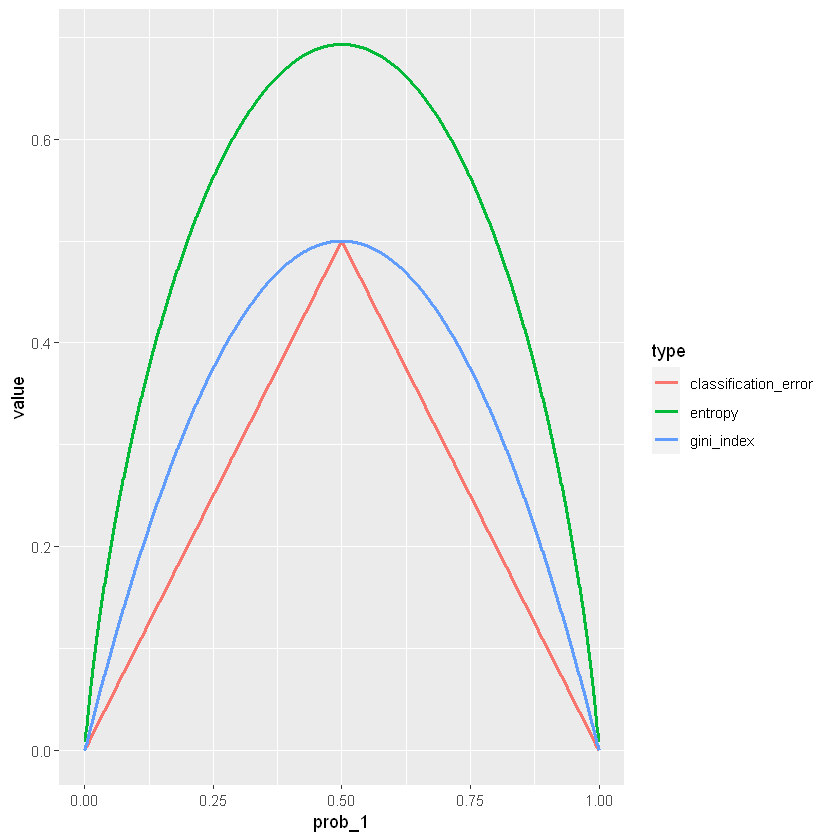

In [2]:
prob_1 = seq(0,1,0.001)
prob_2 = 1-prob_1

classification_error <- 1 - pmax(prob_1, prob_2)
gini_index <- prob_1*(1-prob_1) + prob_2*(1-prob_2)
entropy <- -(prob_1*log(prob_1) + prob_2*log(prob_2))

df <- data.frame(prob_1, classification_error, gini_index, entropy)

pivot_longer(df, cols = c(classification_error, gini_index, entropy), names_to = 'type')%>%
ggplot(aes(x = prob_1, y = value, col = type))+
geom_line(size = 1)

## Question 5

In [3]:
p_red <- c(0.1, 0.15, 0.2, 0.2, 0.55,0.6,0.6,0.65,0.7,0.75)

if (sum(p_red >= 0.5) >  sum(p_red < 0.5)){
    print('Majority is Red')
} else {
    print('Majority is Green')
}

[1] "Majority is Red"


## Question 8
## a

In [4]:
head(Carseats)

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<fct>,<fct>
1,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
2,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
3,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
4,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
5,4.15,141,64,3,340,128,Bad,38,13,Yes,No
6,10.81,124,113,13,501,72,Bad,78,16,No,Yes


In [5]:
set.seed(42)  
train_idx <- sample(1:nrow(Carseats), 250)
train_df <- Carseats[train_idx, ] 
test_df <- Carseats[-train_idx, ]

## b

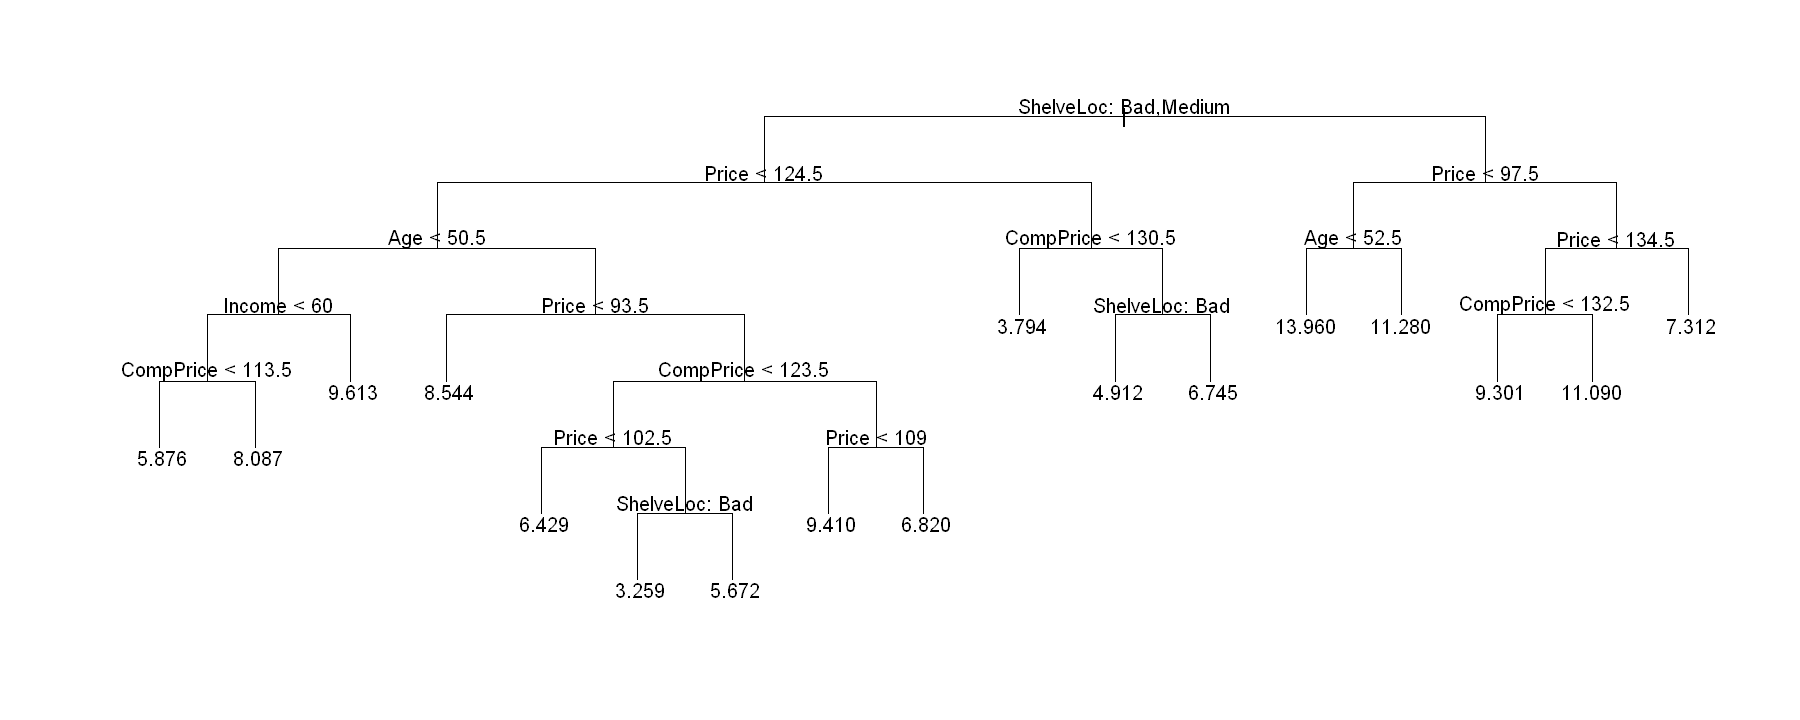

In [6]:
# Fit full regression tree (top-down greedy splitting)
md_regtree <- tree(Sales ~ ., data=train_df)

# Plot the regression tree
options(repr.plot.width=15, repr.plot.height=6)
plot(md_regtree, type='uniform')
text(md_regtree, pretty=0)

In [7]:
summary(md_regtree)


Regression tree:
tree(formula = Sales ~ ., data = train_df)
Variables actually used in tree construction:
[1] "ShelveLoc" "Price"     "Age"       "Income"    "CompPrice"
Number of terminal nodes:  17 
Residual mean deviance:  2.465 = 574.3 / 233 
Distribution of residuals:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-5.0740 -0.8975 -0.1001  0.0000  1.1040  3.5490 

In [8]:
pred <- predict(md_regtree, test_df)

mse <- mean((pred - test_df$Sales)^2)

print(mse)

[1] 5.054926


## c

In [9]:
# Prune the Regression Tree
set.seed(1)
cv_regtree <- cv.tree(md_regtree)
cv_regtree

$size
 [1] 17 16 15 14 12 11 10  9  7  6  5  4  3  2  1

$dev
 [1] 1161.202 1183.973 1177.768 1188.237 1189.590 1213.654 1251.978 1342.276
 [9] 1342.276 1343.125 1503.468 1600.934 1560.037 1659.740 2037.963

$k
 [1]      -Inf  22.24697  23.30787  23.94030  25.15050  30.77944  33.26100
 [8]  62.09667  62.47101  66.61141  82.53546 113.93878 125.58879 204.41804
[15] 419.02969

$method
[1] "deviance"

attr(,"class")
[1] "prune"         "tree.sequence"

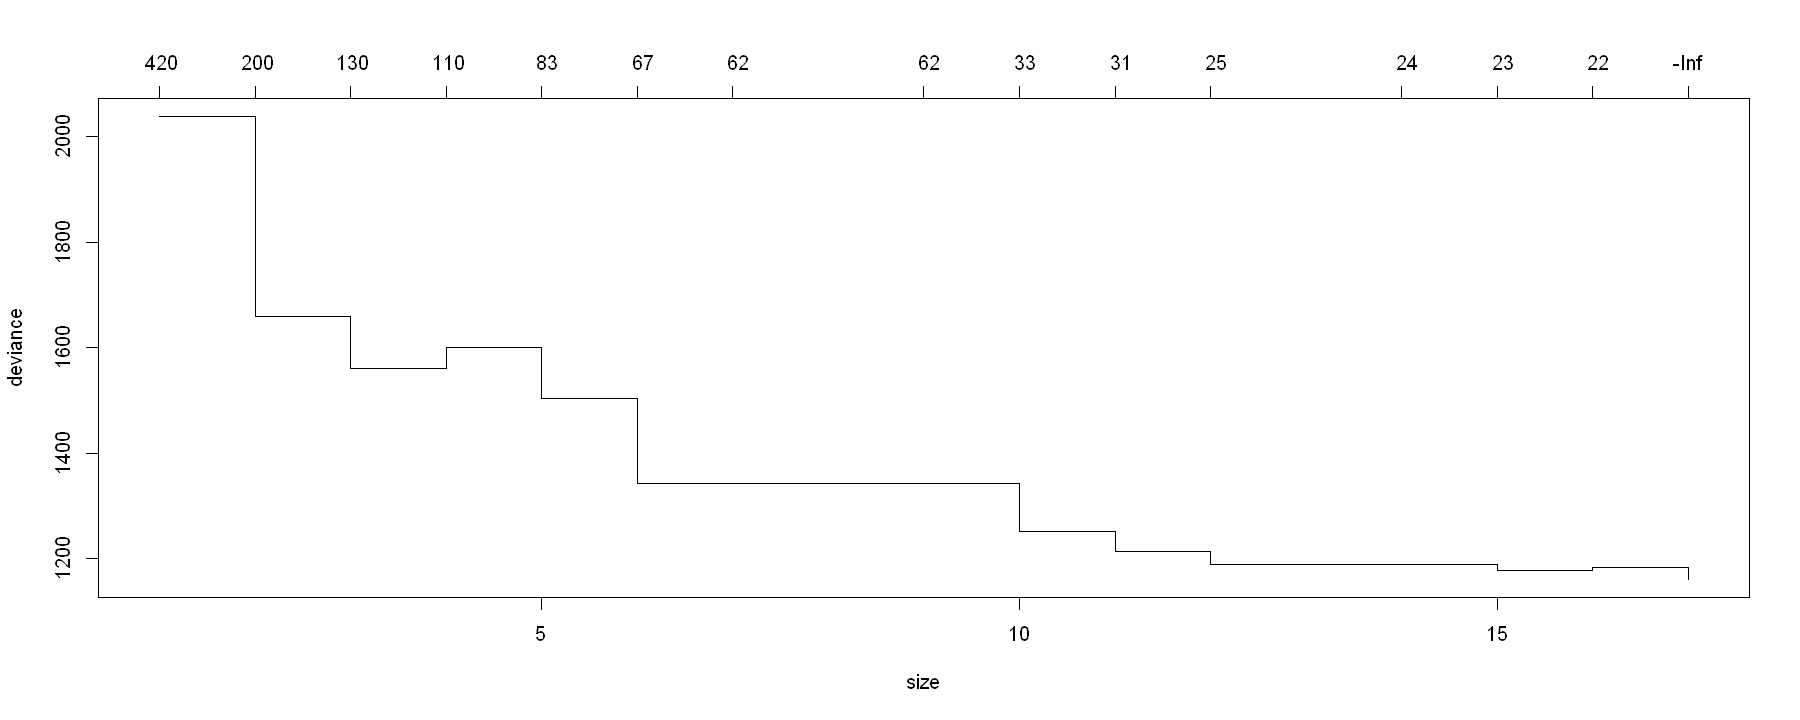

In [10]:
plot(cv_regtree)

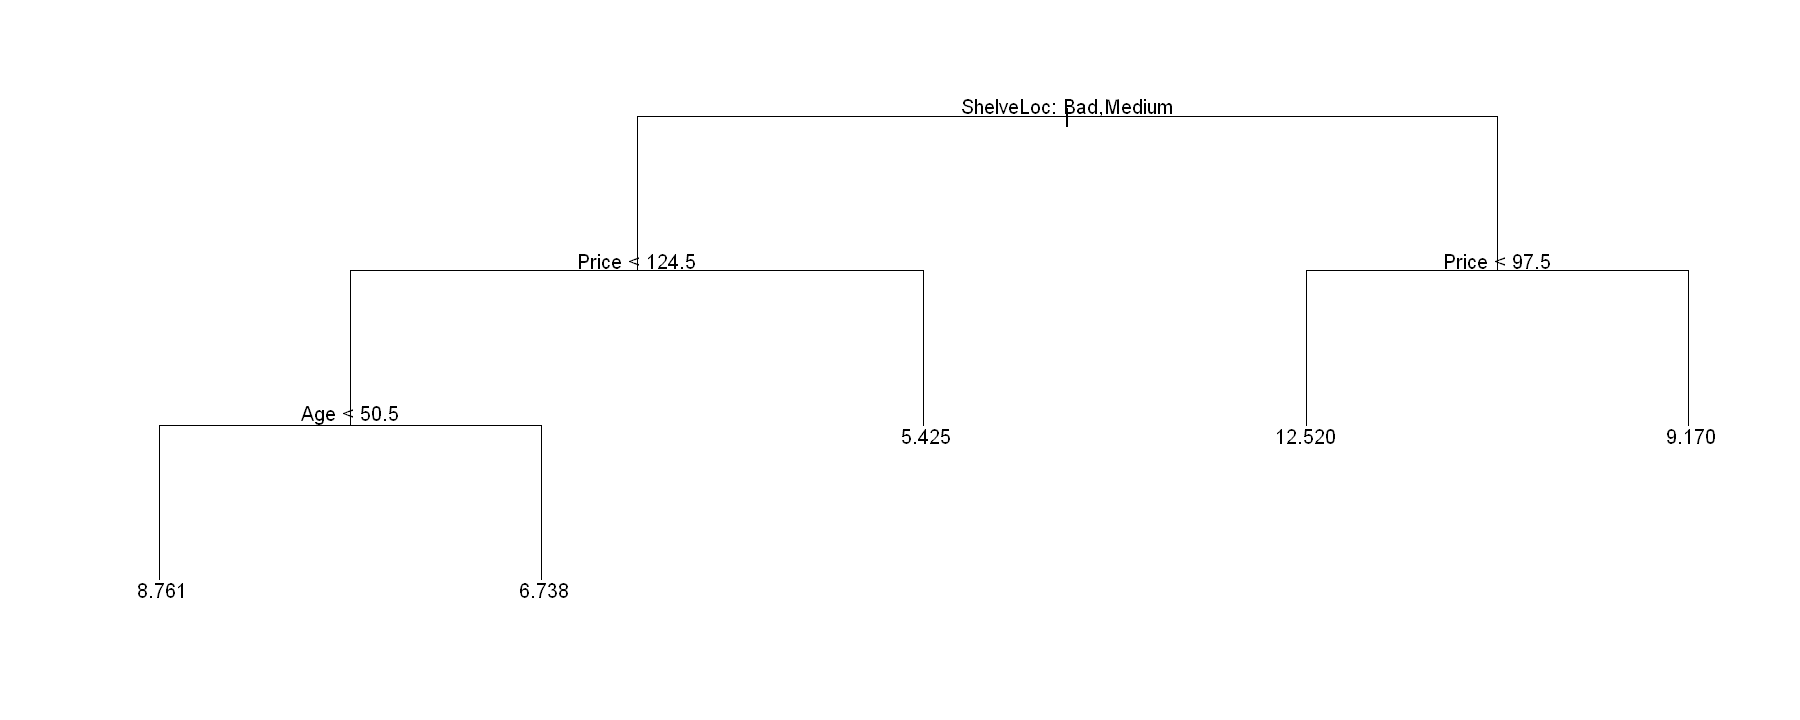

In [11]:
# Prune the tree
prune_regtree <- prune.tree(md_regtree, best=5)

# Show the tree
options(repr.plot.width=15, repr.plot.height=6)
plot(prune_regtree, type='uniform')
text(prune_regtree, pretty=0)

In [12]:
prune_pred <- predict(prune_regtree, test_df)

prune_mse <- mean((prune_pred - test_df$Sales)^2)

print(prune_mse)

[1] 4.813867


### pruning reduced the MSE

## d

In [13]:
# Fit random forests model
set.seed(1)
md_rf <- randomForest(Sales ~ ., data=train_df, mtry=6, importance = TRUE)
md_rf


Call:
 randomForest(formula = Sales ~ ., data = train_df, mtry = 6,      importance = TRUE) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 6

          Mean of squared residuals: 2.753929
                    % Var explained: 64.82

In [14]:
bagging_pred <- predict(md_rf, test_df)

bagging_mse <- mean((bagging_pred - test_df$Sales)^2)

print(bagging_mse)

[1] 2.376077


In [15]:
importance(md_rf)

,%IncMSE,IncNodePurity
CompPrice,26.585997,223.05322
Income,7.949040,126.76030
Advertising,16.311636,181.04316
Population,3.135143,105.45092
Price,50.934018,493.59983
ShelveLoc,53.625282,477.01012
Age,14.753288,195.11036
Education,3.882937,67.01593
Urban,2.764709,12.37230
US,2.388890,12.00545


## Question 9

## a

In [16]:
head(OJ)

,Purchase,WeekofPurchase,StoreID,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,SalePriceMM,SalePriceCH,PriceDiff,Store7,PctDiscMM,PctDiscCH,ListPriceDiff,STORE
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
1,CH,237,1,1.75,1.99,0.00,0.0,0,0,0.500000,1.99,1.75,0.24,No,0.000000,0.000000,0.24,1
2,CH,239,1,1.75,1.99,0.00,0.3,0,1,0.600000,1.69,1.75,-0.06,No,0.150754,0.000000,0.24,1
3,CH,245,1,1.86,2.09,0.17,0.0,0,0,0.680000,2.09,1.69,0.40,No,0.000000,0.091398,0.23,1
4,MM,227,1,1.69,1.69,0.00,0.0,0,0,0.400000,1.69,1.69,0.00,No,0.000000,0.000000,0.00,1
5,CH,228,7,1.69,1.69,0.00,0.0,0,0,0.956535,1.69,1.69,0.00,Yes,0.000000,0.000000,0.00,0
6,CH,230,7,1.69,1.99,0.00,0.0,0,1,0.965228,1.99,1.69,0.30,Yes,0.000000,0.000000,0.30,0


In [17]:
set.seed(42)  
train_idx <- sample(1:nrow(OJ), 800)
train_df <- OJ[train_idx, ] 
test_df <- OJ[-train_idx, ]

## b

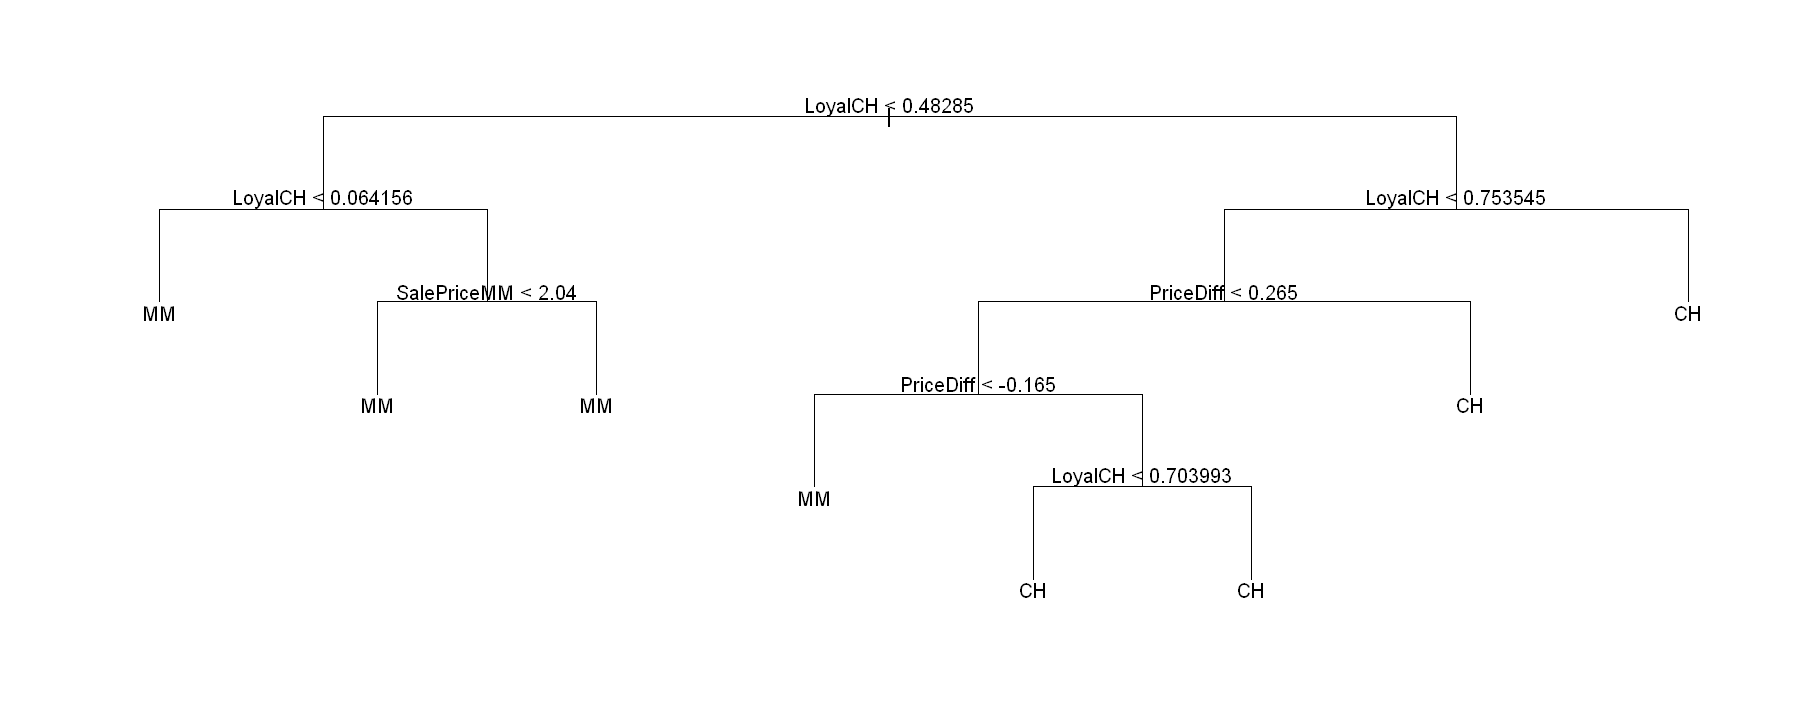

In [18]:
# Fit full regression tree (top-down greedy splitting)
regtree <- tree(Purchase ~ ., data=train_df)

# Plot the regression tree
options(repr.plot.width=15, repr.plot.height=6)
plot(regtree, type='uniform')
text(regtree, pretty=0)

In [19]:
summary(regtree)


Classification tree:
tree(formula = Purchase ~ ., data = train_df)
Variables actually used in tree construction:
[1] "LoyalCH"     "SalePriceMM" "PriceDiff"  
Number of terminal nodes:  8 
Residual mean deviance:  0.7392 = 585.5 / 792 
Misclassification error rate: 0.1638 = 131 / 800 

In [20]:
test_pred <- predict(regtree, test_df, type = "class")
table(test_pred, test_actual = test_df$Purchase)

         test_actual
test_pred  CH  MM
       CH 125  15
       MM  36  94

In [21]:
test_error <- 1 - mean(test_pred == test_df$Purchase)
test_error

[1] 0.1888889

In [22]:
cv_tree <- cv.tree(regtree, FUN = prune.misclass)
cv_tree

$size
[1] 8 5 2 1

$dev
[1] 152 152 155 308

$k
[1]       -Inf   0.000000   4.666667 163.000000

$method
[1] "misclass"

attr(,"class")
[1] "prune"         "tree.sequence"

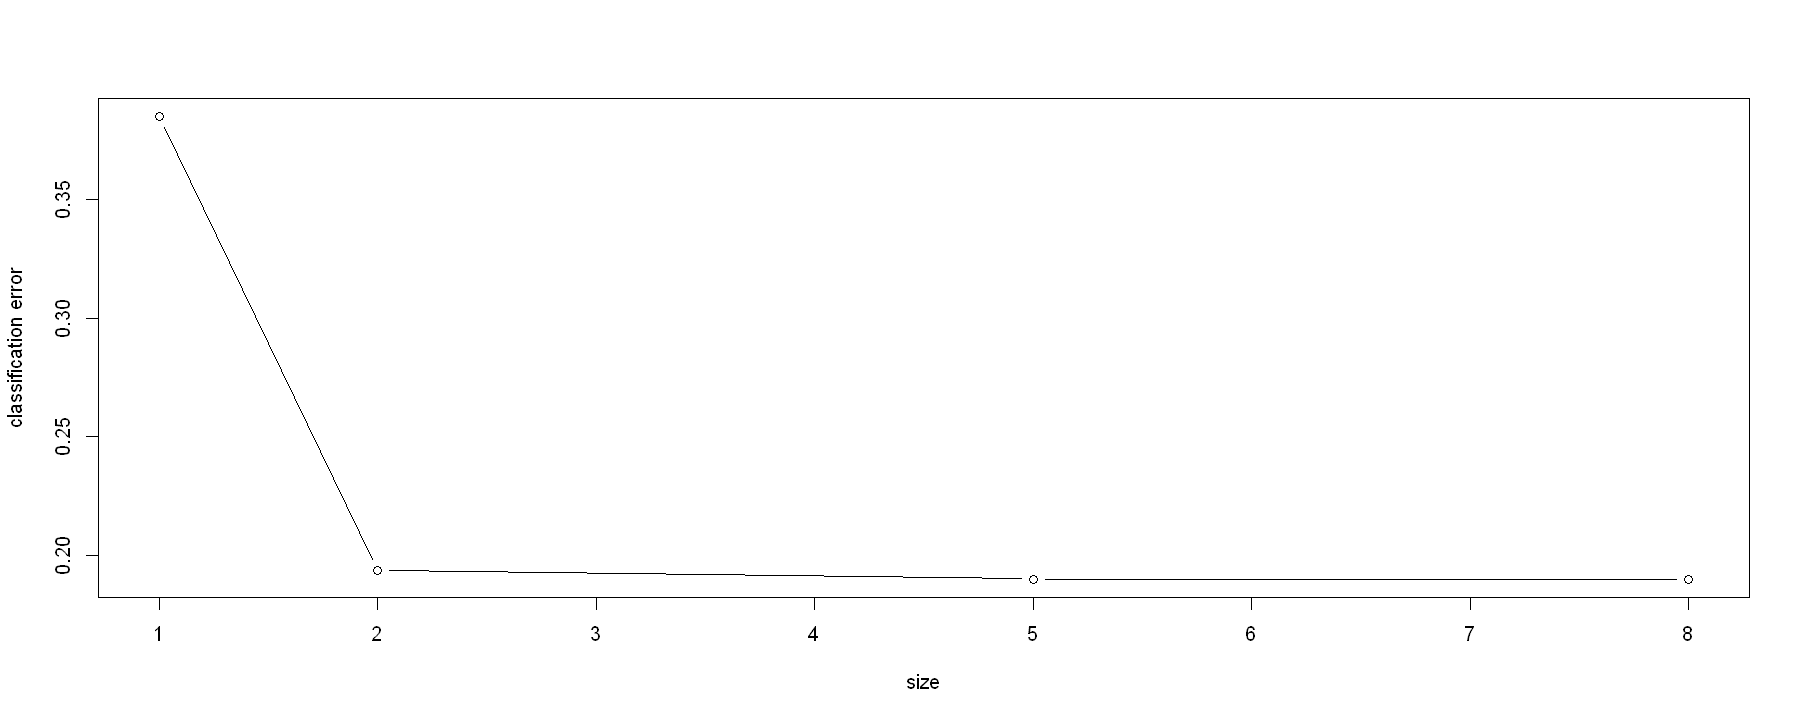

In [23]:
plot(cv_tree$size, cv_tree$dev/nrow(train_df), type = 'b' , xlab = 'size', ylab = 'classification error')

## h

### tree size 5 has the lower cross validation error

## i

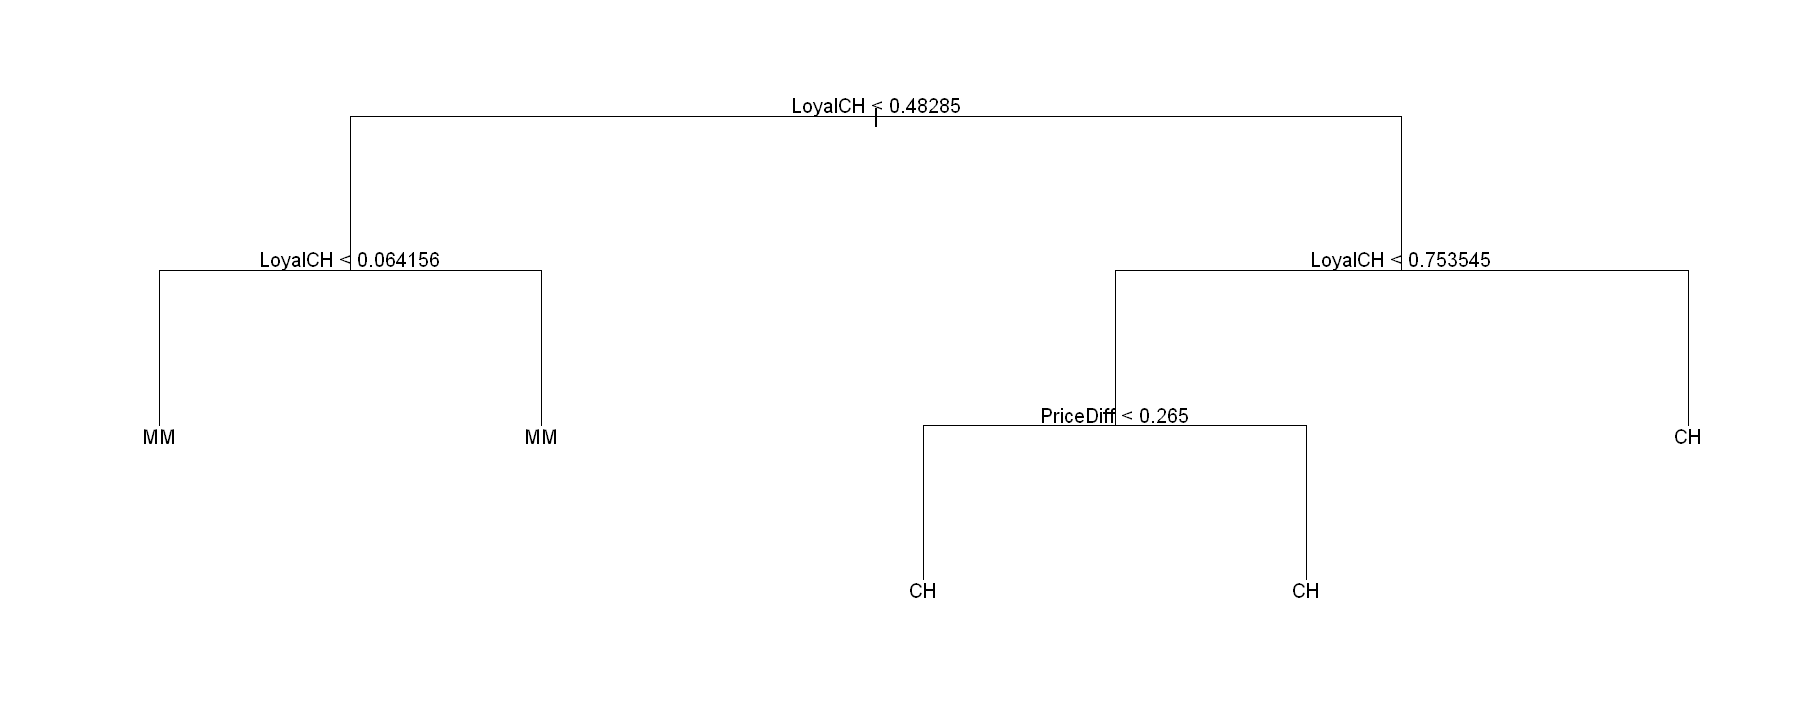

In [24]:
# Prune the tree
prune_regtree <- prune.tree(regtree, best=5)

# Show the tree
options(repr.plot.width=15, repr.plot.height=6)
plot(prune_regtree, type='uniform')
text(prune_regtree, pretty=0)

## j

In [25]:
mean(predict(regtree, type = "class") != train_df$Purchase)

[1] 0.16375

In [26]:
mean(predict(prune_regtree, type = "class") != train_df$Purchase) # pruned is higher

[1] 0.18125

In [27]:
mean(predict(regtree, newdata = test_df, type = "class") != test_df$Purchase)

[1] 0.1888889

In [28]:
mean(predict(prune_regtree, newdata = test_df, type = "class") != test_df$Purchase)

[1] 0.2185185

## k
### Pruned test error is higher

## Question 10

In [29]:
#part a
ht <- Hitters[!is.na(Hitters$Salary),]

In [30]:
ht$Salary <- log(ht$Salary)

In [31]:
# part b

set.seed(42)  
train_idx <- sample(1:nrow(ht), 200)
train_df <- ht[train_idx, ] 
test_df <- ht[-train_idx, ]

In [32]:
# part c
lambda<- 10^seq(-6, -0.1, 0.1)
set.seed(1)
train_MSE <- c()
test_MSE <- c()
for (i in 1:length(lambda)) {
md_boosttree <- gbm(Salary ~ ., data=train_df,
                    distribution='gaussian',
                    n.trees=1000,  # Number of boosting iteration
                    shrinkage = lambda[i]) 
        pred <- predict(md_boosttree, train_df, n.trees=1000)

        
        train_MSE[i] <-  mean((pred - train_df$Salary) ^ 2) 
        pred_2 <- predict(md_boosttree, test_df, n.trees=1000)
        test_MSE[i] <-  mean((pred_2 - test_df$Salary) ^ 2) 
    }

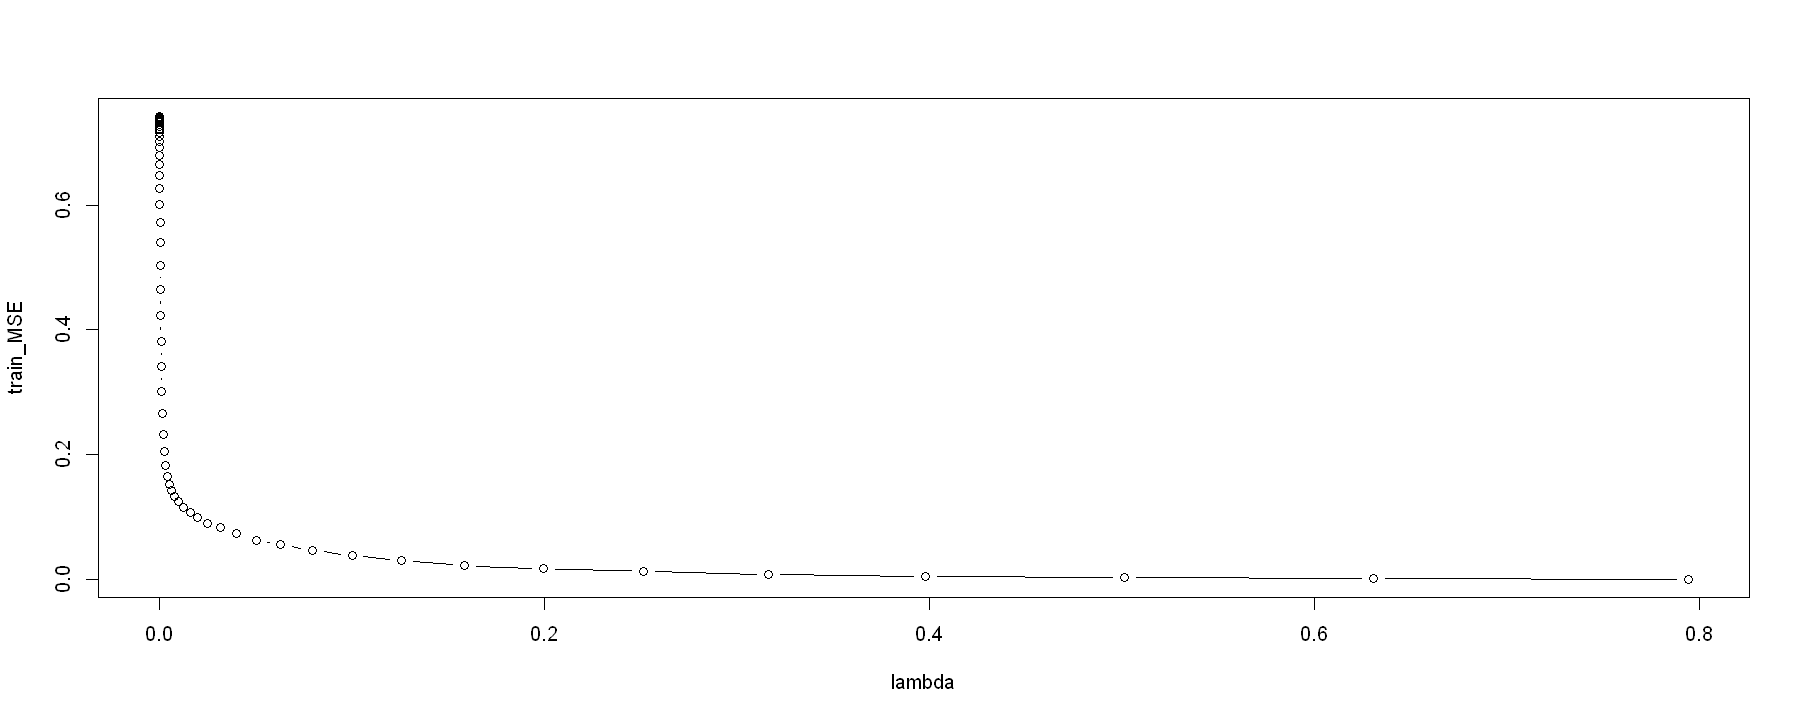

In [33]:
plot(lambda, train_MSE, type = 'b')

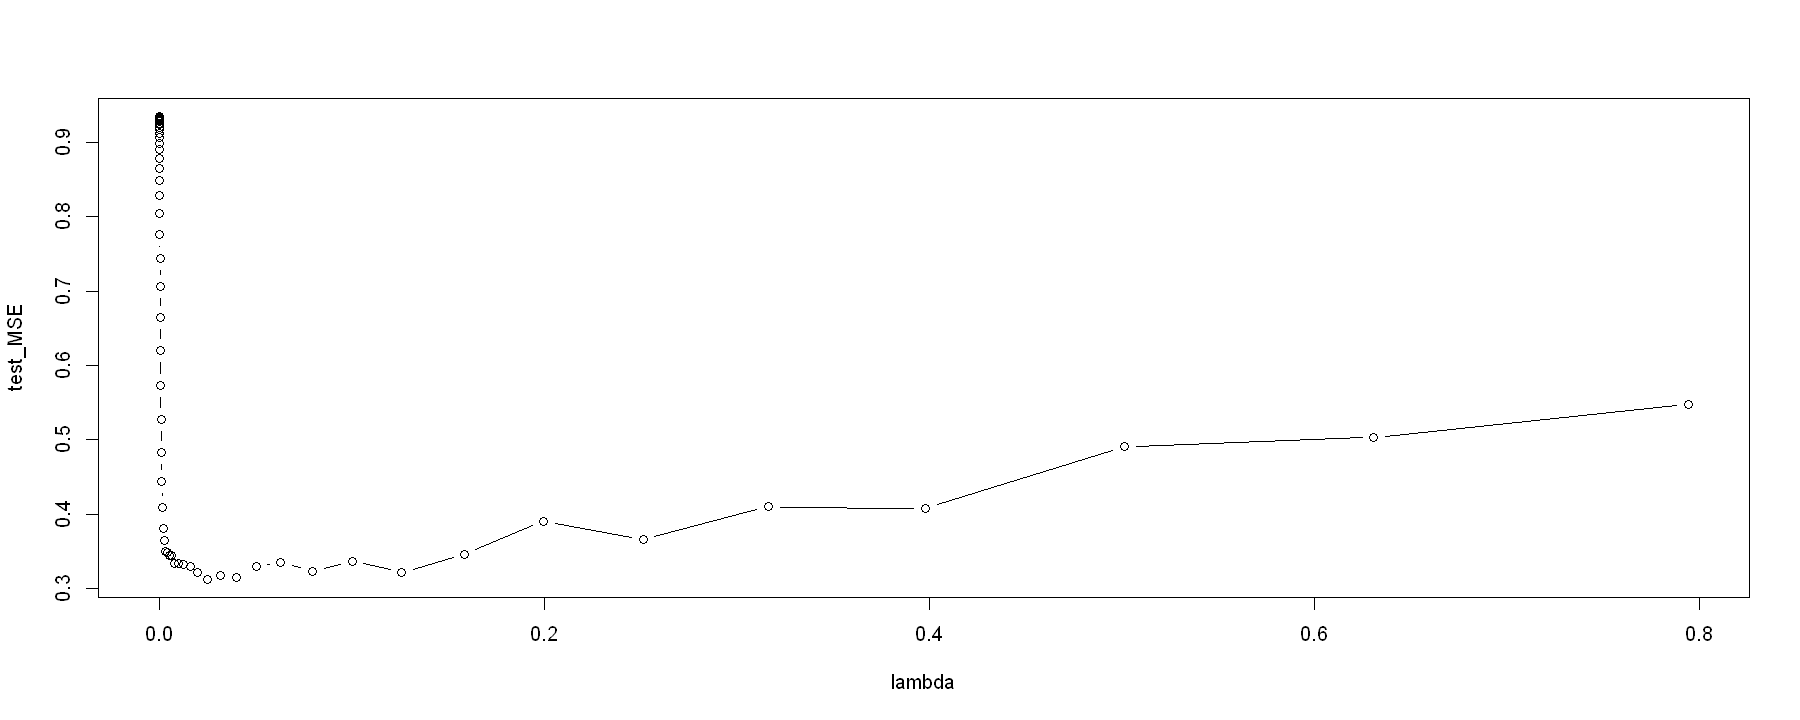

In [34]:
plot(lambda, test_MSE, type = 'b')

In [35]:
# part e
min(test_MSE)

[1] 0.3123792

In [36]:
linear_reg <- lm(Salary ~ ., data = train_df)

pred_linear <- predict(linear_reg, newdata = test_df)

MSE <- mean((pred_linear - test_df$Salary) ^ 2) 
MSE

[1] 0.6037436

In [37]:
library(glmnet)
X_train <- model.matrix(Salary ~ ., data = train_df)
y_train <- train_df$Salary

X_test <- model.matrix(Salary ~ ., data = test_df)

lasso_mod <- glmnet(X_train, y_train, alpha = 1)

lasso_pred <- predict(lasso_mod, s = 0.01, newx = X_test)

MSE<-mean((lasso_pred - test_df$Salary)^2)
MSE

Loading required package: Matrix


Attaching package: 'Matrix'


The following objects are masked from 'package:tidyr':

    expand, pack, unpack


Loaded glmnet 4.1-2



[1] 0.5971061

,var,rel.inf
,<chr>,<dbl>
CHits,CHits,24.7695281
CAtBat,CAtBat,14.1422867
CRBI,CRBI,9.8414573
PutOuts,PutOuts,6.4910083
Walks,Walks,5.9776565
HmRun,HmRun,4.6550050
AtBat,AtBat,4.2128411
CHmRun,CHmRun,4.1331843
CWalks,CWalks,4.0764748


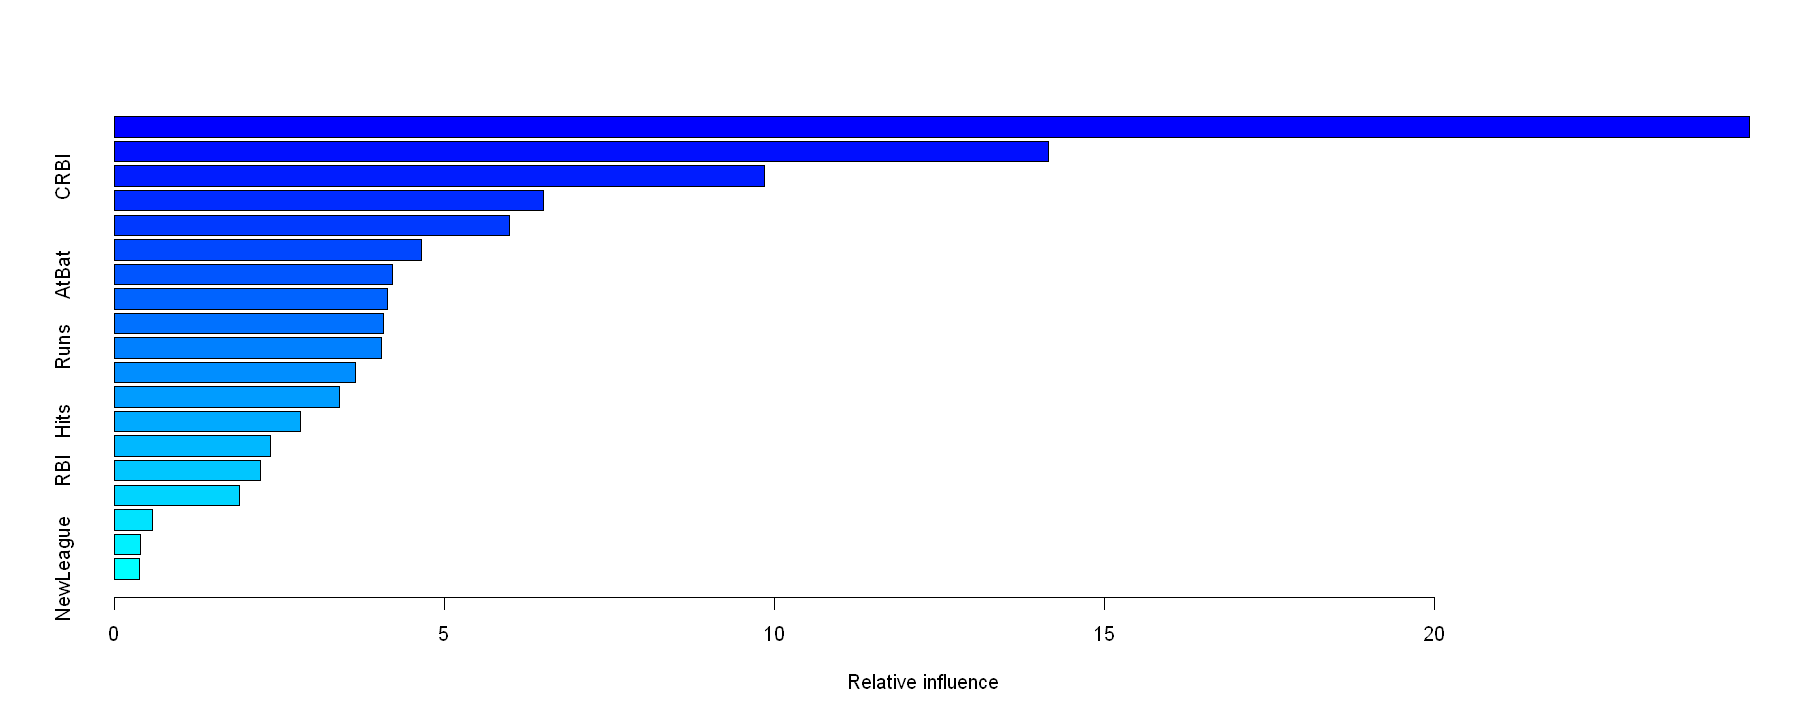

In [38]:
#part f

set.seed(3)
boosttree <- gbm(Salary ~ ., data=train_df, distribution='gaussian',
                    n.trees=1000, interaction.depth=4, shrinkage=min(test_MSE))

summary(boosttree)

In [39]:
# part g

# Fit random forests model
set.seed(1)
md_rf <- randomForest(Salary ~ ., data=train_df, mtry=6, importance = TRUE)
md_rf

bagging_pred <- predict(md_rf, test_df)

bagging_mse <- mean((bagging_pred - test_df$Salary)^2)

print(bagging_mse)


Call:
 randomForest(formula = Salary ~ ., data = train_df, mtry = 6,      importance = TRUE) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 6

          Mean of squared residuals: 0.1931961
                    % Var explained: 73.97

[1] 0.2507402
